## Imports

In [145]:
import pickle
import gzip
import os
import time
import copy
import cv2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Utility Functions

In [363]:
def print_train_data_point(item, verbose=False):
    name = item['name']   #
    video = item['video'] #
    box = item['box']
    label = item['label']
    frames = item['frames'] #
    dataset = item['dataset'] #
    
    print(f"Dataset: {dataset}, Name: {name}\nVideo Shape:   {video.shape}\nLabeld Frames: {frames}")
    if verbose:
        print(f"Box Shape:   {box.shape}\nLabel Shape: {label.shape}")
    print()
    
def resize_boolean_array(b_item, shape=(128, 128)):
    # Step 1: Convert boolean to uint8 (True -> 255, False -> 0)
    b_item_uint8 = b_item.astype(np.uint8) * 255
    
    # Step 2: Resize the array with nearest-neighbor interpolation
    size = (shape[1],shape[0])
    resized_item = cv2.resize(b_item_uint8, size, interpolation=cv2.INTER_NEAREST)
    
    # Step 3: Convert back to boolean (any value >= 127 is True)
    resized_item_boolean = resized_item >= 127
    
    return resized_item_boolean

def extract_box_coords_batch(boolean_batch):
    
    batch_size = boolean_batch.shape[0]
    coordinates = []
    
    for i in range(batch_size):
        boolean_array = boolean_batch[i]
        height, width = boolean_array.shape
        #print(boolean_array)
        
        x1 = None
        y1 = None
        x2 = None
        y2 = None
        i = 0
        
        for h in range(height):
            for w in range(width):
                if boolean_array[h][w] == True:
                    x2, y2 = h, w
                    if (i==0):
                        x1, y1 = h, w
                    i += 1
                               
        coordinates.append((x1, y1, x2, y2))
            
    return torch.FloatTensor(np.array(coordinates))

def reconstruct_box_coords_batch(coords_batch, shape=(128,128)):
    
    batch_size = coords_batch.shape[0]
    boxes = []
    
    for i in range(batch_size):
        x1, y1, x2, y2 = coords_batch[i,:].detach().numpy().astype(int)
        box = np.zeros(shape, dtype=bool)
        box[x1:x2+1, y1:y2+1] = True
        boxes.append(box)
    
    return torch.BoolTensor(np.array(boxes))

def calculate_box_area(x1, y1, x2, y2):
    # Ensure the coordinates are within the image bounds
    if x1 < 0 or y1 < 0 or x2 > 128 or y2 > 128:
        raise ValueError("Box coordinates are outside the image bounds.")
    if x1 >= x2 or y1 >= y2:
        raise ValueError("Invalid box coordinates: (x1, y1) must be top-left and (x2, y2) bottom-right.")
    
    # Calculate the width and height of the box
    width = x2 - x1
    height = y2 - y1
    
    # Calculate and return the area
    return width * height

## Graphing Functions

In [297]:
def plot_frame(frame, title, mask=None):
    
    # Apply the mask to the copy if provided
    frame_with_mask = frame.copy()
    frame_without_mask = frame.copy()
    if mask is not None:
        frame_with_mask[~mask] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(frame_without_mask, cmap='gray')
    title0 = title + " without mask"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(frame_with_mask, cmap='gray')
    title1 = title + " with mask"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()
    
def show_video(frames, masks, speed=0.025):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title("Masked Frame")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Load Data

In [242]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
        
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")
print(f"Test set items:{len(test_data)}")

100%|██████████| 65/65 [00:00<00:00, 168.41it/s]

Amateur Train set items:46
Expert Train set items:19
All Train set items:65
Test set items:20


In [244]:
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
#          test_data

100%|██████████| 65/65 [00:00<00:00, 126.97it/s]


## Create Datasets

In [246]:
class EchoDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, test=False,transform=None):
        self.frames_data = frames_data  # Numpy array: (num_frames, height, width)
        self.boxes_data = boxes_data    # Numpy array: (num_frames, height, width)
        
        if not test:
            self.labels_data = labels_data  # Numpy array: (num_frames, height, width)
        else:
            self.labels_data = None
            
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        box = self.boxes_data[index]     # shape (height, width)
        label = self.labels_data[index]   # shape (height, width)

        frame = torch.FloatTensor(frame) 
        box = torch.BoolTensor(box)
        label = torch.FloatTensor(label) 

        return frame, box, label

    def __len__(self):
        return len(self.frames_data)

In [248]:
def get_resized_normalized_list(data):
    f = []
    b = []
    l = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i]
            
            f.append(cv2.resize(f_item.astype(np.uint8), (128, 128)))
            b.append(resize_boolean_array(b_item, shape=(128, 128)))
            l.append(cv2.resize(l_item.astype(np.uint8), (128, 128)))

    return f, b, l

f_a, b_a, l_a = get_resized_normalized_list(train_data_amateurs)
f_e, b_e, l_e = get_resized_normalized_list(train_data_experts)
f_ae, b_ae, l_ae = get_resized_normalized_list(train_data_all)

100%|██████████| 65/65 [00:00<00:00, 770.74it/s]


In [250]:
amateur_train_dataset = EchoDataset(f_a, b_a, l_a)
expert_train_dataset = EchoDataset(f_e, b_e, l_e)
all_train_dataset = EchoDataset(f_ae, b_ae, l_ae)

a = all_train_dataset.__len__()
b = amateur_train_dataset.__len__()
c = expert_train_dataset.__len__()

print(f"{a/3}, {b/3}, {c/3}")

65.0, 46.0, 19.0


## Models

In [253]:
class BoxPositionModel(nn.Module):
    def __init__(self):
        super(BoxPositionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # Output: 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 32x64x64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 64x32x32
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output: 128x32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: 128x16x16
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 4) # Output: 4 coordinates (x1, y1, x2, y2)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

## Train Box finding

In [338]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(all_train_dataset, batch_size=16, shuffle=True)

model = BoxPositionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for frame_batch, box_batch, label_batch in train_loader: # images: (batch_size, 1, 128, 128), targets: (batch_size, 4)
            optimizer.zero_grad()
            outputs = model(frame_batch.unsqueeze(1))
            loss = criterion(outputs, extract_box_coords_batch(box_batch))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        
train_model(train_loader, model, criterion, optimizer, num_epochs=20)

Epoch 1/20, Loss: 7267.1276127741885
Epoch 2/20, Loss: 595.1331458458534
Epoch 3/20, Loss: 260.8576202392578
Epoch 4/20, Loss: 126.2824935913086
Epoch 5/20, Loss: 100.91822756253757
Epoch 6/20, Loss: 84.04877736018254
Epoch 7/20, Loss: 70.56453558114859
Epoch 8/20, Loss: 58.72236413222093
Epoch 9/20, Loss: 48.72519012597891
Epoch 10/20, Loss: 31.991343608269325
Epoch 11/20, Loss: 25.378936180701622
Epoch 12/20, Loss: 20.94686398139367
Epoch 13/20, Loss: 14.657425623673658
Epoch 14/20, Loss: 13.718739472902739
Epoch 15/20, Loss: 13.606337583982027
Epoch 16/20, Loss: 8.523646868192232
Epoch 17/20, Loss: 12.136408677467934
Epoch 18/20, Loss: 9.174080261817345
Epoch 19/20, Loss: 4.930368808599619
Epoch 20/20, Loss: 3.723112234702477


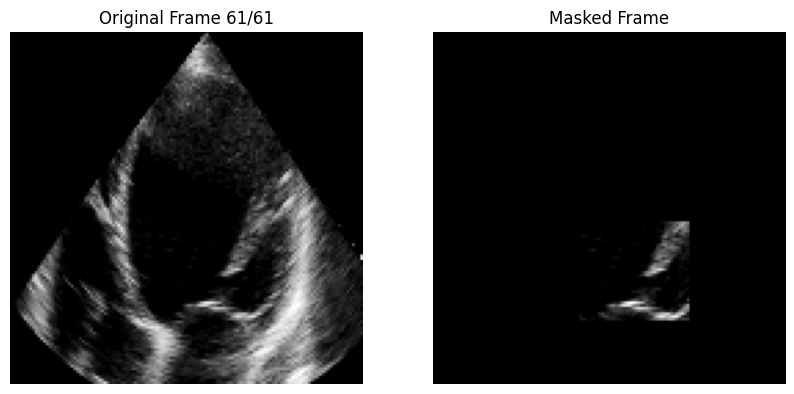

In [348]:
test_video_0 = test_data[3]['video']
vid = np.zeros((128,128,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (128, 128))
   

model.eval()
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)
#print(frames.shape)


model.eval()
frame_box_coords = model(frames)
boxes=reconstruct_box_coords_batch(frame_box_coords)

video_frames = frames.squeeze().permute(1, 2, 0)
video_boxes = boxes.permute(1, 2, 0)
#print(video_frames.shape)
#print(video_boxes.shape)

show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy(), speed=0.1)


In [369]:
# TESTING

maxi = 0
mini = 10000
b=0

for frame_batch, box_batch, label_batch in train_loader:
    b = b+1
    extracted_box_batch = extract_box_coords_batch(box_batch)
    for i in range(16):
        coords = extracted_box_batch[i].detach().numpy()
        area = calculate_box_area(coords[0], coords[1], coords[2], coords[3])
        if area>maxi:
            maxi = area
        if area<mini:
            mini = area
    print(f"Batch {b}")
    print(maxi)
    print(mini)

Batch 1
1870.0
800.0
Batch 2
2262.0
800.0
Batch 3
2320.0
494.0
Batch 4
2320.0
494.0
Batch 5
2501.0
494.0
Batch 6
2501.0
494.0
Batch 7
2501.0
494.0
Batch 8
2501.0
494.0
Batch 9
2501.0
494.0
Batch 10
2501.0
494.0
Batch 11
2501.0
494.0
Batch 12
2501.0
494.0


IndexError: index 3 is out of bounds for dimension 0 with size 3